In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

In [1]:
!nvidia-smi

Sat Apr  1 14:29:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import sklearn
import numpy as np
from glob import glob
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline 

import string
from os import listdir
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from pickle import dump
from string import punctuation

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#load data
#df = pd.read_csv('/content/drive/MyDrive/Bangla Datasets/FINAL_BANGLA_DB/bengali_Toxic_balance.csv', encoding='UTF-8')
#df = pd.read_csv('/content/drive/MyDrive/Bangla Datasets/FINAL_BANGLA_DB/bengali_Toxic_balance_upload.csv')
#df = pd.read_csv('/content/drive/MyDrive/Bangla Datasets/FINAL_BANGLA_DB/bengali_Toxic_balance_upload_with_augment.csv')
#df = pd.read_csv('/content/drive/MyDrive/Bangla Datasets/FINAL_BANGLA_DB/bengali_Toxic_balance_upload_with_augment_Final_balance_nonTox.csv', encoding='UTF-8')
df = pd.read_csv('/kaggle/input/toxicdb/Multi_labeled_toxic_comments.csv')
#df = df.drop(['Toxic', 'NonToxic'], axis=1 )
#reset index
#df.set_index('id', inplace = True)
df.head()

text  vulgar  hate  religious  \
0  প্রধানমন্ত্রী হক সাহেবের ক্ষতি হলে জাতির স্বার...       0     0          0   
1                                   আমি বললাম, ‘দেন’       0     0          0   
2  অসাধারণ তানজিন তিশা আমার বালো লাগার একজনকাতার ...       0     0          0   
3                                  তার উপর ২ জন মেয়র       0     0          0   
4  পলাশের কাজ এতো ভালো হবে কল্পনাও করি নাই তৌহিদে...       0     0          0   

   threat  troll  Insult  
0       1      0       0  
1       0      0       0  
2       0      0       0  
3       0      0       0  
4       0      0       0

In [4]:
filter = df["text"] != ""
df = df[filter]
df = df.dropna()

In [5]:
#df = df.drop(['Toxic', 'NonToxic'], axis=1 )
df = df.sample(frac=1).reset_index(drop=True)
df.head()

text  vulgar  hate  religious  \
0                                       “বিয়ের গিফট”       0     0          0   
1                অসাধারণ অভিনয় বিশেষ করে নিসো ভাইয়ের       0     0          0   
2  নিজের দেশের অসাধারন নাটকনা দেখে যারা ইন্ডিয়ার ...       0     0          0   
3  ইসলাম বিদ্বেষী নাস্তিক ব্লগার আসিফ মহিউদ্দিন-এ...       0     0          1   
4  অনুভূতি গুলো সত্যি অন্যরকম এক কথায় অসাধারণ একট...       0     0          0   

   threat  troll  Insult  
0       0      0       0  
1       0      0       0  
2       0      0       0  
3       0      0       0  
4       0      0       0

In [6]:
df = df.loc[((df['vulgar'] == 1) | (df['hate'] == 1) | (df['religious'] ==1) | (df['threat'] == 1) | (df['troll'] == 1) | (df['Insult'] ==1))]

In [7]:
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

text  vulgar  hate  religious  \
0                   টুপি পইরাও খেমা পাইলিনা মাদারচুত       1     0          1   
1  বাংলাদেশ সরকার কে এটা স্বরণ রাখা উচিত যে সালে ...       0     1          0   
2  তোমরা কেউ কি আবাল দেখতে চাও তাহলে আর দেরি নয়.....       0     0          0   
3  আমার মনে হয় ভারতীয় সেনাবাহিনী পাকিদের ভয় পায় ক...       0     1          0   
4  নেপালের মতো আমাদের দেশেও ভারতীয় তিন চ্যানেল বন...       0     1          0   

   threat  troll  Insult  
0       0      0       1  
1       0      0       0  
2       0      1       1  
3       0      0       0  
4       0      0       0

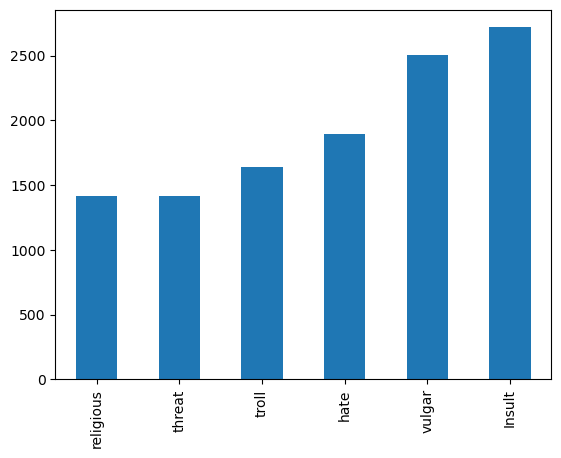

In [8]:
LABEL_COLUMNS = df.columns.tolist()[1:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="bar");

In [9]:
df[LABEL_COLUMNS].sum()

vulgar       2505
hate         1898
religious    1418
threat       1419
troll        1643
Insult       2719
dtype: int64

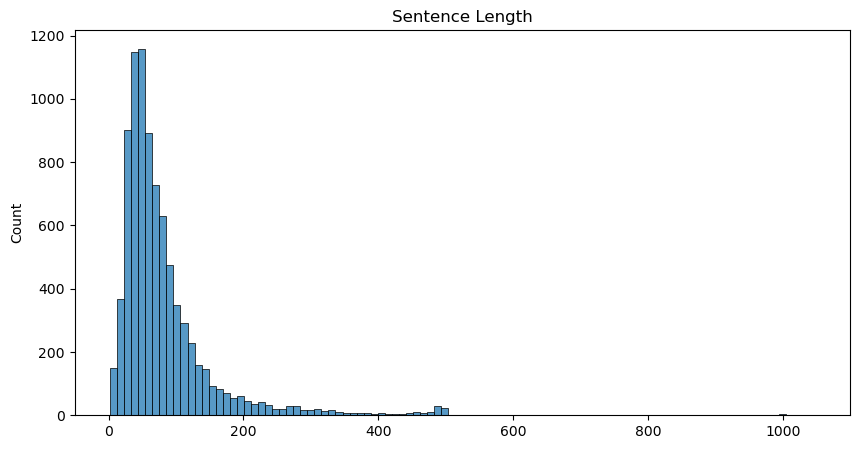

In [10]:
#need equal length sentences
#plot hist of sentence length
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in df.text], bins=100)
plt.title('Sentence Length')
plt.show()

In [11]:
stop_word_list = (stopwords.words('bengali'))

In [12]:
import string 

# turn a doc into clean tokens
def clean_doc(doc):
	doc = doc.replace("”","")
	doc = doc.replace("“","")
	# split into tokens by white space
	tokens = doc.split()
    
	# remove punctuation from each token
	table = str.maketrans('', '', string.punctuation)
	tokens = [w.translate(table) for w in tokens]
    
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if not word.isalpha()]
    
	# filter out stop words
	#stop_words = stop_word_list
	#tokens = [w for w in tokens if not w in stop_words]
    
	# filter out short tokens
	tokens = [word for word in tokens if len(word) > 1]
	tokens = ' '.join(tokens)
	return tokens

In [13]:
df['text'] = df.text.apply(clean_doc)

In [14]:
sample_row = df.iloc[125]
sample_comment = sample_row.text
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print(sample_labels.to_dict())

ক্লাসে সুন্দরি ম্যাডামের ঘটলে লুচ্চা ছাত্রদের অবস্থা
{'vulgar': 0, 'hate': 0, 'religious': 0, 'threat': 0, 'troll': 1, 'Insult': 0}


**Train Test Split**

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [16]:
%%capture
!pip3 install iterative-stratification
!pip install scikit-multilearn

In [17]:
X = df['text']

In [18]:
y = df[['vulgar', 'hate', 'religious', 'threat', 'troll', 'Insult']]
y

vulgar  hate  religious  threat  troll  Insult
0          1     0          1       0      0       1
1          0     1          0       0      0       0
2          0     0          0       0      1       1
3          0     1          0       0      0       0
4          0     1          0       0      0       0
...      ...   ...        ...     ...    ...     ...
8483       0     0          1       0      0       0
8484       0     0          1       0      0       0
8485       0     0          0       0      1       0
8486       1     0          0       0      0       1
8487       0     0          1       0      0       1

[8488 rows x 6 columns]

In [19]:
X = X.to_numpy()
y = y.to_numpy()

In [20]:
'''from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
msss = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.40, random_state=42)
for train_index, test_index in msss.split(X, y):
        x_train, x_test_temp = X[train_index], X[test_index]
        y_train, y_test_temp = y[train_index], y[test_index]'''

'from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit\nmsss = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.40, random_state=42)\nfor train_index, test_index in msss.split(X, y):\n        x_train, x_test_temp = X[train_index], X[test_index]\n        y_train, y_test_temp = y[train_index], y[test_index]'

In [21]:
'''msss = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.4, random_state=42)
for val_index, test_index in msss.split(x_test_temp, y_test_temp):
        x_val, x_test = X[val_index], X[test_index]
        y_val, y_test = y[val_index], y[test_index]'''

'msss = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.4, random_state=42)\nfor val_index, test_index in msss.split(x_test_temp, y_test_temp):\n        x_val, x_test = X[val_index], X[test_index]\n        y_val, y_test = y[val_index], y[test_index]'

In [22]:
# open the file in read binary mode 
train_file = open("/kaggle/input/toxicdb-array/x_train", "rb")
val_file = open("/kaggle/input/toxicdb-array/x_val", "rb")
test_file = open("/kaggle/input/toxicdb-array/x_test", "rb")

#read the file to numpy array
x_train = np.load(train_file, allow_pickle=True)
x_val = np.load(val_file, allow_pickle=True)
x_test = np.load(test_file, allow_pickle=True)

#close the file
train_file.close
val_file.close
test_file.close

<function BufferedReader.close>

In [23]:
# open the file in read binary mode
train_label = open("/kaggle/input/toxicdb-array/y_train", "rb")
val_label = open("/kaggle/input/toxicdb-array/y_val", "rb")
test_label = open("/kaggle/input/toxicdb-array/y_test", "rb")

#read the file to numpy array
y_train = np.load(train_label, allow_pickle=True)
y_val = np.load(val_label, allow_pickle=True)
y_test = np.load(test_label, allow_pickle=True)

#close the file
train_label.close
val_label.close
test_label.close

<function BufferedReader.close>

In [24]:
train_text = pd.DataFrame(x_train, columns = ['text'])
train_label = pd.DataFrame(y_train, columns = ['vulgar', 'hate', 'religious', 'threat', 'troll', 'Insult'])
train_df = pd.concat([train_text, train_label], axis=1, join='inner')
train_df = train_df.loc[((train_df['vulgar'] == 1) | (train_df['hate'] == 1) | (train_df['religious'] ==1) | (train_df['threat'] == 1) | (train_df['troll'] == 1) | (train_df['Insult'] ==1))]
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df

text  vulgar  hate  \
0            সিঙ্গেল মেয়েদের দুধু বারোভাতারি মেয়ের দুধু       1     0   
1                 তুমি দাঁড়িয়ে থাকার আগে পুদ মেরে যাও       1     0   
2     অভিশপ্ত কোটা প্রথার কারনে বাপের নামে সন্তান খা...       0     1   
3     বিশ্বের অষ্টম জনবসতির দেশ হয়েও বাংলাদেশ নিজে ...       0     1   
4     বাংলাদেশকে অতি সত্তর বিশ্ব থেকে বাদ দেওয়া উচিত...       1     0   
...                                                 ...     ...   ...   
5088                      ভারত শয়তানেরা খারাপ কাজ পারে।       0     1   
5089  জলু ফাগুন কোন পর্যন্ত আসছে রে এটা কোন হিমালয় থ...       0     0   
5090     ফলাফল আম্মু কর্তৃক শাহী উত্তম মধ্যমের ব্যবস্থা       0     0   
5091  তুই কী মাগির পুত নাকী হিজরার পুত এতো গালি পাড়ে...       1     0   
5092  দয়া করে অকৃতজ্ঞ মানুষের নিয়ে কোনো ভিডিও বানিয়ে...       0     1   

      religious  threat  troll  Insult  
0             0       0      0       1  
1             0       0      0       0  
2             0       0      0       0  
3             0       0      0       0  
4             0       0      0       0  
...         ...     ...    ...     ...  
5088          0       0      0       0  
5089          0       0      1       0  
5090          0       0      1       0  
5091          0       0      0       1  
5092          0       0      0       0  

[5093 rows x 7 columns]

In [25]:
x_train = train_df['text']
y_train = train_df[['vulgar', 'hate', 'religious', 'threat', 'troll', 'Insult']]
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()

In [26]:
val_text = pd.DataFrame(x_val, columns = ['text'])
val_label = pd.DataFrame(y_val, columns = ['vulgar', 'hate', 'religious', 'threat', 'troll', 'Insult'])
val_df = pd.concat([val_text, val_label], axis=1, join='inner')
val_df = val_df.loc[((val_df['vulgar'] == 1) | (val_df['hate'] == 1) | (val_df['religious'] ==1) | (val_df['threat'] == 1) | (val_df['troll'] == 1) | (val_df['Insult'] ==1))]
val_df = val_df.sample(frac=1).reset_index(drop=True)
val_df

text  vulgar  hate  \
0     আপনারা ব্যস্ত সেই বিয়ের আসরে বালতি ঢেলে দেওয়ার...       0     0   
1     জাতিসংঘ কিছুয়ে দেখবেনা মুসলমান হইলে সাতে সাতে ...       0     0   
2     বৃষ্টিতে ধুয়ে গেছে রক্তের লাল মুছেনি তো হৃদয়ের...       0     0   
3     অতীন্দ্রদার মতো মানুষের প্রতি তার কোনো কৃতজ্ঞত...       0     0   
4     আজাহারী যে জঙ্গি আস্তানার বীজ করে গেছে জন্যই ত...       0     0   
...                                                 ...     ...   ...   
2061                     তোরা মালাউনরা তোদের মা বোন চোদ       1     0   
2062  দিকে কি একটু শক্ত করে চোষ ঘষা হলে ব্যাথা বাড়ব...       1     0   
2063  হাসিনার একদিন বিচার হবে আল্লাহ পাক তাকে থেকে উ...       0     0   
2064  কি মুক্তিযুদ্ধের চেতেনা বাস্তবায়নের একটি পদক্ষ...       0     0   
2065  কেয়ামত খুব নিটকে এইটা মুখোশধারী নাস্তিক কথায় প...       0     0   

      religious  threat  troll  Insult  
0             0       0      1       0  
1             1       0      0       0  
2             1       0      0       0  
3             0       0      0       1  
4             1       0      0       0  
...         ...     ...    ...     ...  
2061          1       0      0       1  
2062          0       0      0       0  
2063          0       1      0       0  
2064          0       0      1       0  
2065          1       0      0       0  

[2066 rows x 7 columns]

In [27]:
x_val = val_df['text']
y_val = val_df[['vulgar', 'hate', 'religious', 'threat', 'troll', 'Insult']]
x_val = x_val.to_numpy()
y_val = y_val.to_numpy()

In [28]:
test_text = pd.DataFrame(x_test, columns = ['text'])
test_label = pd.DataFrame(y_test, columns = ['vulgar', 'hate', 'religious', 'threat', 'troll', 'Insult'])
test_df = pd.concat([test_text, test_label], axis=1, join='inner')
test_df = test_df.loc[((test_df['vulgar'] == 1) | (test_df['hate'] == 1) | (test_df['religious'] ==1) | (test_df['threat'] == 1) | (test_df['troll'] == 1) | (test_df['Insult'] ==1))]
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df

text  vulgar  hate  \
0     দিদি যে বৃক্ষ ছায়া দেয় তার একটা পাতা আদরনীয় হয়...       1     0   
1     তোরে কাছে পেলে জুতার মালা গলায় দিয়ে তিন রাস্তা...       0     0   
2     আমাদের হিন্দু ধর্মে বিয়ে করার কোনো নিয়ম নেই জন...       0     0   
3     ভারতে ট্রেন দূর্ঘটনায় সবাই শোক প্রকাশ করতে পার...       1     0   
4         থেকে তোর মতো শুয়োরের বাচ্চার নাটক দেখা করলাম       1     0   
...                                                 ...     ...   ...   
1364                ছিড়া বাটা জুতা দিয়ে মুখে মারা দরকার       0     0   
1365  ডির্ভোস দিবো তুমাকে আগেই না করছিলাম লাইনে না য...       0     0   
1366  আপনার ধর্মে নারীদের শস‍্যক্ষেত্রের সঙ্গে তুলনা...       0     0   
1367  বালের হাইব্রিড সাবমেরিন ভারত পাত্তা দেয় না বাং...       0     1   
1368                           জুতা পেটা করমু খাংকি তরে       1     0   

      religious  threat  troll  Insult  
0             0       0      0       1  
1             1       1      0       1  
2             1       0      0       0  
3             1       0      0       0  
4             0       1      0       1  
...         ...     ...    ...     ...  
1364          0       1      0       1  
1365          0       1      0       0  
1366          1       0      0       0  
1367          0       0      0       0  
1368          0       1      0       1  

[1369 rows x 7 columns]

In [29]:
x_test = test_df['text']
y_test = test_df[['vulgar', 'hate', 'religious', 'threat', 'troll', 'Insult']]
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

In [30]:
print("Data ->Vulgar, Hate, Religious, Threat, Troll, Insult")
print("Train: ", y_train.sum(axis = 0))
print("Validation: ", y_val.sum(axis = 0))
print("Test: ", y_test.sum(axis = 0))

Data ->Vulgar, Hate, Religious, Threat, Troll, Insult
Train:  [1503 1139  851  851  986 1631]
Validation:  [624 445 324 343 424 653]
Test:  [440 294 229 224 254 469]


In [31]:
y_test

array([[1, 0, 0, 0, 0, 1],
       [0, 0, 1, 1, 0, 1],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 1]])

In [32]:
len(x_train), len(x_val), len(x_test)

(5093, 2066, 1369)

In [33]:
len(y_train), len(y_val), len(y_test)

(5093, 2066, 1369)

**BERT WORD EMBEDDING**

In [34]:
%%capture
!pip3 install transformers
#!pip install transformers

In [35]:
from transformers import AutoModelForPreTraining, AutoTokenizer
from transformers import BertTokenizer, TFBertModel

In [36]:
# hyperparameters
max_length = 300
batch_size = 16
#dev_size = 0.2

In [37]:
import tensorflow as tf

In [38]:
tokenizer = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base")

In [39]:
X_input_ids_train = np.zeros((len(x_train), max_length))
X_attn_masks_train = np.zeros((len(x_train), max_length))

X_input_ids_dev = np.zeros((len(x_val), max_length))
X_attn_masks_dev = np.zeros((len(x_val), max_length))

X_input_ids_test = np.zeros((len(x_test), max_length))
X_attn_masks_test = np.zeros((len(x_test), max_length))

In [40]:
from tqdm import tqdm
def preprocessing_dataset(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df)):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=max_length, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [41]:
X_input_ids_tain, X_attn_masks_tain = preprocessing_dataset(x_train, X_input_ids_train, X_attn_masks_train, tokenizer)
X_input_ids_dev, X_attn_masks_dev = preprocessing_dataset(x_val, X_input_ids_dev, X_attn_masks_dev, tokenizer)
X_input_ids_test, X_attn_masks_test = preprocessing_dataset(x_test, X_input_ids_test, X_attn_masks_test, tokenizer)

5093it [00:13, 372.45it/s]
2066it [00:02, 834.78it/s]
1369it [00:01, 839.14it/s]


In [42]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_input_ids_tain, X_attn_masks_tain, y_train))
dev_dataset = tf.data.Dataset.from_tensor_slices((X_input_ids_dev, X_attn_masks_dev, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_input_ids_test, X_attn_masks_test, y_test))

In [43]:
def VulgarDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [44]:
train_dataset = train_dataset.map(VulgarDatasetMapFunction)
dev_dataset = dev_dataset.map(VulgarDatasetMapFunction)
test_dataset = test_dataset.map(VulgarDatasetMapFunction)

In [45]:
train_dataset = train_dataset.shuffle(100).batch(batch_size) 
dev_dataset = dev_dataset.shuffle(100).batch(batch_size) 
test_dataset = test_dataset.shuffle(100).batch(batch_size) 


In [46]:
import tensorflow as tf
from keras.optimizers import adam_v2
'''from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential'''
from tensorflow.keras.optimizers import Adam

In [47]:
from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional
from keras.models import Sequential
from keras.layers import CuDNNLSTM

In [48]:
import keras
from keras.preprocessing.text import Tokenizer
#from keras_preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers import LSTM
from keras.layers.convolutional import MaxPooling1D
from keras.layers import concatenate
from pickle import load

from keras.layers import Conv1D, MaxPooling2D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed

In [49]:
#Import necessary libraries
# demonstration of calculating metrics for a neural network model using sklearn
import keras.backend as K
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.metrics import Metric


def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  #Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0.0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def auroc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


def fmeasure(y_true, y_pred):
    '''Calculates the f-measure, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)


fscore = f1score = fmeasure

In [50]:
from keras import initializers as initializers, regularizers, constraints
REG_PARAM = 1e-13
#l2_reg = regularizers.l2(REG_PARAM)

In [51]:
def bert_model():
    bert_encoder = TFBertModel.from_pretrained("sagorsarker/bangla-bert-base")
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    attn_masks = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

    encoder_embedding_layer = bert_encoder(input_word_ids, attention_mask=attn_masks)[0]   

    conv1D_1 = tf.keras.layers.Conv1D(512, 4, activation='relu',name='con1')(encoder_embedding_layer)
    maxPool1D_1 = tf.keras.layers.MaxPooling1D(pool_size=2,name='maxpool1')(conv1D_1)

    conv1D_2 = tf.keras.layers.Conv1D(256, 3, activation='relu',name='con2')(maxPool1D_1)
    maxPool1D_2 = tf.keras.layers.MaxPooling1D(pool_size=2,name='maxpool2')(conv1D_2)

    conv1D_3 = tf.keras.layers.Conv1D(128, 2, activation='relu',name='con3')(maxPool1D_2)
    maxPool1D_3 = tf.keras.layers.MaxPooling1D(pool_size=2,name='maxpool3')(conv1D_3)

    '''
    # Apply Bidirectional LSTM over embedded inputs
    lstm_outs = keras.layers.wrappers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True)
    )(maxPool1D_3)

    '''
    # Apply Bidirectional LSTM over embedded inputs
    lstm_outs = Bidirectional(keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(REG_PARAM)))(maxPool1D_3)

   

    # Attention Mechanism - Generate attention vectors
    #attention_output = AttentionLayer(lstm_outs)
    input_dim = int(lstm_outs.shape[2])
    permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs)
    attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
    #print(attention_vector.shape)
    attention_vector = keras.layers.Reshape((attention_vector.shape[1],))(attention_vector)
    attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
    #attention_vector = keras.layers.Activation('relu', name='attention_vec')(attention_vector)
    #attention_vector = keras.layers.Activation('tanh', name='attention_vec')(attention_vector)
    attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])
    
    # Last layer: fully connected with softmax activation
    fc = keras.layers.Dense(64, activation='relu')(attention_output)
    output = keras.layers.Dense(6, activation='sigmoid')(fc)

    # Finally building model
    model = keras.Model(inputs=[input_word_ids, attn_masks], outputs=output)
   
      
    return model

In [52]:
model = bert_model()

Some layers from the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at sagorsarker/bangla-bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [53]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              #optimizer=tf.keras.optimizers.Adam(1e-5),
              optimizer=tf.keras.optimizers.legacy.Adam(1e-5),
              metrics=['accuracy', fmeasure, precision, recall])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 300)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  164396544   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                           

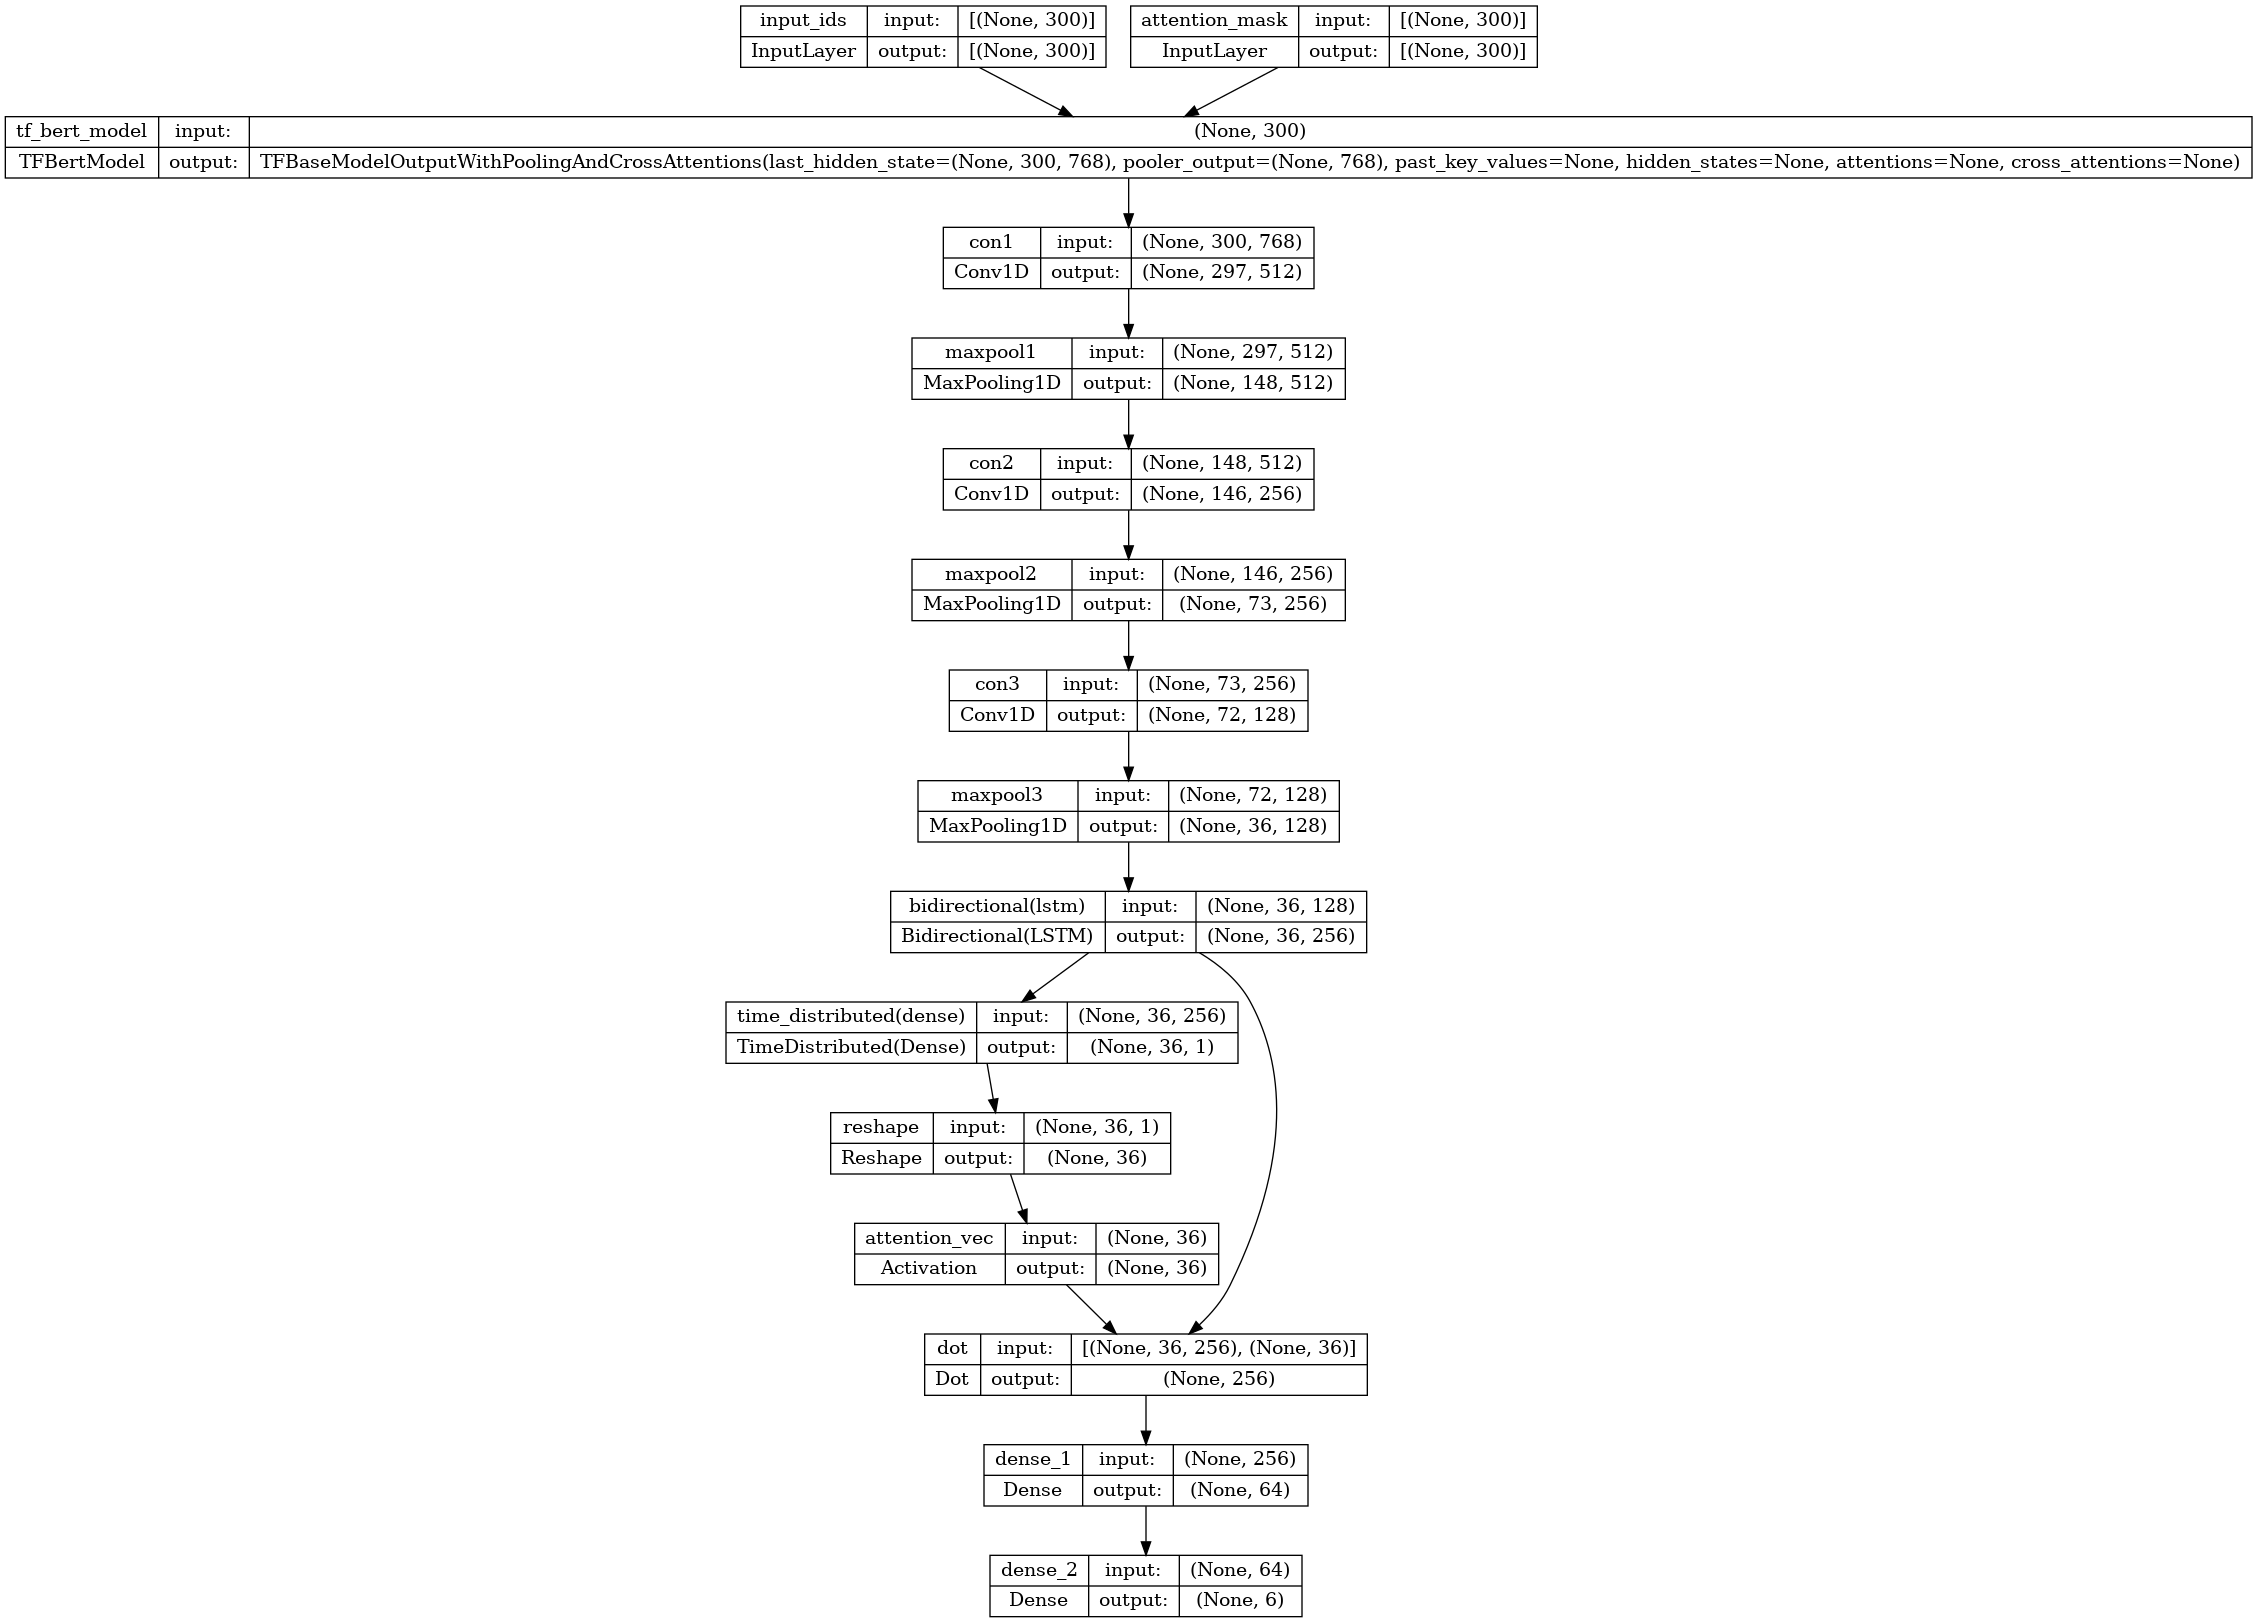

In [54]:
#plot the vulgar detection model architecture
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='toxic_detection_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='toxic_detection_model_plot.png')

In [55]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [56]:
'''
#checkpoint which stores the weights of the model when maximum validation accuracy is found
checkpoint_filepath = "weights.best.hdf5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

history = model.fit(
    train_dataset,
    batch_size=32,
    epochs=9,
    validation_data=dev_dataset,
    validation_steps=20,
    verbose=1,
    callbacks=[checkpoint])
'''

'\n#checkpoint which stores the weights of the model when maximum validation accuracy is found\ncheckpoint_filepath = "weights.best.hdf5"\n\ncheckpoint = tf.keras.callbacks.ModelCheckpoint(\n    filepath=checkpoint_filepath,\n    save_weights_only=True,\n    monitor=\'val_acc\',\n    mode=\'max\',\n    save_best_only=True)\n\nhistory = model.fit(\n    train_dataset,\n    batch_size=32,\n    epochs=9,\n    validation_data=dev_dataset,\n    validation_steps=20,\n    verbose=1,\n    callbacks=[checkpoint])\n'

In [57]:
#model1 = model
history = model.fit(
    train_dataset,
    batch_size=16,
    epochs=8,
    validation_data=dev_dataset,
    validation_steps=20,
    verbose=1)

Epoch 1/8
319/319 [==============================] - 271s 728ms/step - loss: 0.4771 - accuracy: 0.3075 - fmeasure: 0.2888 - precision: 0.5918 - recall: 0.2077 - val_loss: 0.3960 - val_accuracy: 0.6031 - val_fmeasure: 0.5822 - val_precision: 0.7807 - val_recall: 0.4711
Epoch 2/8
319/319 [==============================] - 220s 690ms/step - loss: 0.3658 - accuracy: 0.6214 - fmeasure: 0.6196 - precision: 0.7729 - recall: 0.5268 - val_loss: 0.3241 - val_accuracy: 0.6719 - val_fmeasure: 0.7004 - val_precision: 0.7582 - val_recall: 0.6558
Epoch 3/8
319/319 [==============================] - 220s 689ms/step - loss: 0.3002 - accuracy: 0.7084 - fmeasure: 0.7248 - precision: 0.8011 - recall: 0.6688 - val_loss: 0.2743 - val_accuracy: 0.7406 - val_fmeasure: 0.7597 - val_precision: 0.7929 - val_recall: 0.7338
Epoch 4/8
319/319 [==============================] - 215s 673ms/step - loss: 0.2491 - accuracy: 0.7642 - fmeasure: 0.7904 - precision: 0.8379 - recall: 0.7529 - val_loss: 0.2448 - val_accuracy:

In [ ]:
#model.save_weights("/content/drive/MyDrive/Colab Notebooks/Belal/CNN_LSTM_ATTENTION_BERT_WITH_ATTENTION_UPD")

In [58]:
test_score = model.evaluate(test_dataset)

print('Test Loss:', test_score[0])
print('Test Accuracy:', test_score[1])

86/86 [==============================] - 21s 239ms/step - loss: 0.2041 - accuracy: 0.8093 - fmeasure: 0.8448 - precision: 0.8680 - recall: 0.8254
Test Loss: 0.20409919321537018
Test Accuracy: 0.8093498945236206


In [68]:
y_pred = model.predict([X_input_ids_test, X_attn_masks_test])

43/43 [==============================] - 17s 398ms/step


In [69]:
len(y_test), len(y_pred)

(1369, 1369)

In [70]:
Threshold = 0.5
upper, lower = 1, 0

In [71]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
y_pred1 = y_pred
y_true = y_test



y_pred1 = np.where(y_pred >= .5, upper, lower)

print(classification_report(
  y_true, 
  y_pred1, 
  digits = 4, 
  target_names=LABEL_COLUMNS, 
  zero_division=0
))

              precision    recall  f1-score   support

      vulgar     0.9172    0.9318    0.9245       440
        hate     0.8117    0.8946    0.8511       294
   religious     0.9307    0.8210    0.8724       229
      threat     0.8848    0.7545    0.8145       224
       troll     0.9375    0.5906    0.7246       254
      Insult     0.8041    0.8401    0.8217       469

   micro avg     0.8677    0.8241    0.8453      1910
   macro avg     0.8810    0.8054    0.8348      1910
weighted avg     0.8737    0.8241    0.8422      1910
 samples avg     0.8600    0.8368    0.8366      1910



In [ ]:
'''
Confusion Matrix for Multilabel
TN   FP
FN   TP
'''

In [73]:
#https://www.kaggle.com/code/kmkarakaya/multi-label-model-evaluation/notebook

from sklearn.metrics import multilabel_confusion_matrix
conf_mat = multilabel_confusion_matrix(y_test, y_pred1)
print(conf_mat)

[[[ 892   37]
  [  30  410]]

 [[1014   61]
  [  31  263]]

 [[1126   14]
  [  41  188]]

 [[1123   22]
  [  55  169]]

 [[1105   10]
  [ 104  150]]

 [[ 804   96]
  [  75  394]]]


In [74]:
conf_mat[5]

array([[804,  96],
       [ 75, 394]])

In [75]:
def multilabel_accuracies(p):
    TP = p[1][1]
    TN = p[0][0]
    FP = p[0][1]
    FN = p[1][0]
    acc = (TP + TN) / (TP + TN + FP + FN)
    print(acc)

In [76]:
confusion_matrix_vulgar = multilabel_confusion_matrix(y_test, y_pred1)[0]
print(confusion_matrix_vulgar)

[[892  37]
 [ 30 410]]


Each label accuracy: 
vulgar
0.9510591672753835
hate
0.9327976625273923
religious
0.9598246895544192
threat
0.943754565376187
troll
0.91672753834916
Insult
0.87509130752374


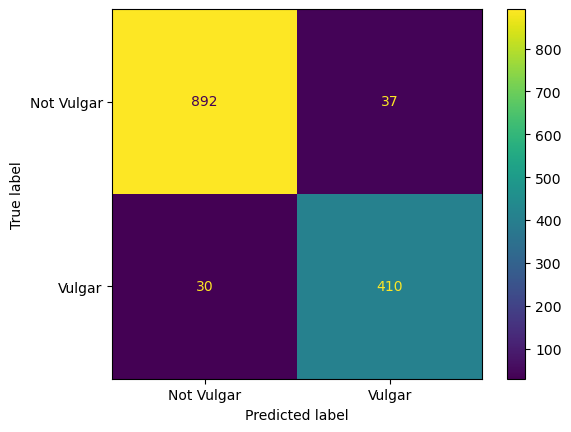

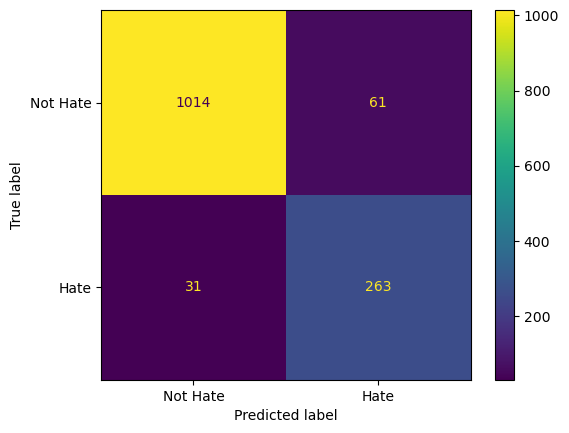

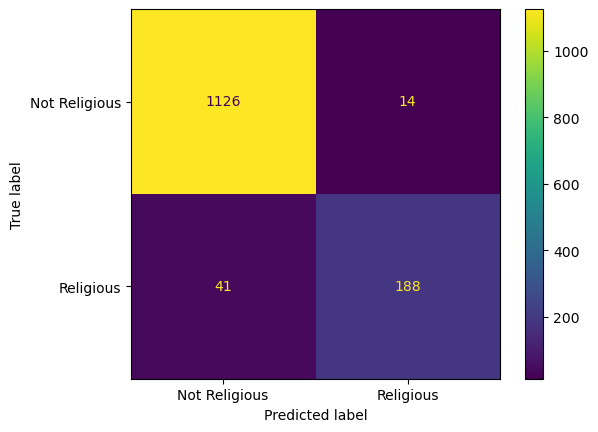

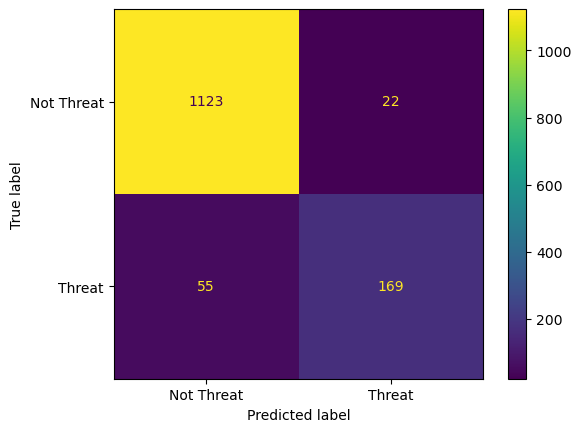

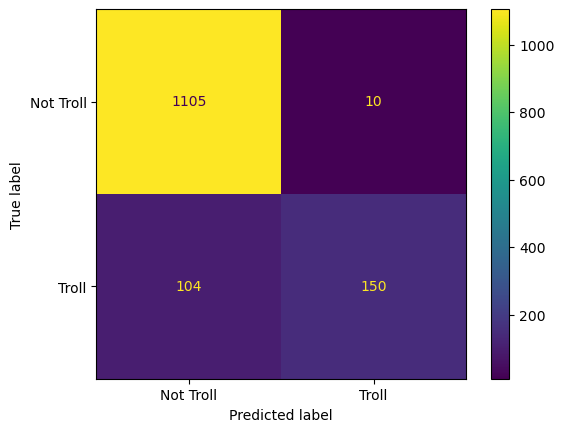

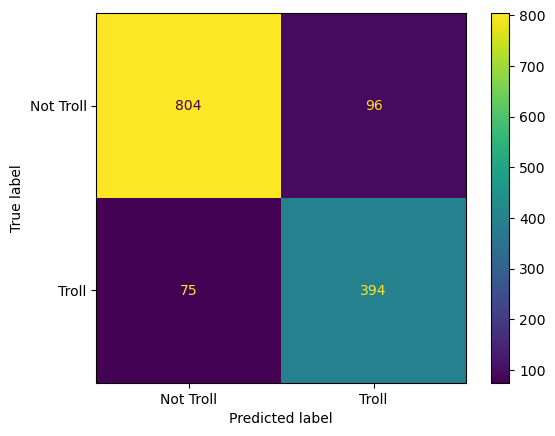

In [78]:
#https://www.kaggle.com/code/kmkarakaya/multi-label-model-evaluation/notebook
y_pred1 = np.where(y_pred >= .5, upper, lower)


from sklearn.metrics import multilabel_confusion_matrix
conf_mat = multilabel_confusion_matrix(y_test, y_pred1)


print("Each label accuracy: ")
for i in range(len(conf_mat)):
    print(LABEL_COLUMNS[i])
    multilabel_accuracies(conf_mat[i])
    
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

vulgar = conf_mat[0]
hate = conf_mat[1]
religious = conf_mat[2]
threat = conf_mat[3]
troll = conf_mat[4]
insult = conf_mat[5]


cm_vulgar = metrics.ConfusionMatrixDisplay(confusion_matrix = vulgar, display_labels = ['Not Vulgar', 'Vulgar'])
cm_hate = metrics.ConfusionMatrixDisplay(confusion_matrix = hate, display_labels = ['Not Hate', 'Hate'])
cm_religious = metrics.ConfusionMatrixDisplay(confusion_matrix = religious, display_labels = ['Not Religious', 'Religious'])
cm_threat = metrics.ConfusionMatrixDisplay(confusion_matrix = threat, display_labels = ['Not Threat', 'Threat'])
cm_troll = metrics.ConfusionMatrixDisplay(confusion_matrix = troll, display_labels = ['Not Troll', 'Troll'])
cm_insult = metrics.ConfusionMatrixDisplay(confusion_matrix = insult, display_labels = ['Not Troll', 'Troll'])

cm_vulgar.plot()
cm_hate.plot()
cm_religious.plot()
cm_threat.plot()
cm_troll.plot()
cm_insult.plot()

plt.show()

In [79]:
print("Each label accuracy: ")
for i in range(len(conf_mat)):
    print(LABEL_COLUMNS[i])
    multilabel_accuracies(conf_mat[i])

Each label accuracy: 
vulgar
0.9510591672753835
hate
0.9327976625273923
religious
0.9598246895544192
threat
0.943754565376187
troll
0.91672753834916
Insult
0.87509130752374


In [80]:
vulgar = conf_mat[0]
hate = conf_mat[1]
religious = conf_mat[2]
threat = conf_mat[3]
troll = conf_mat[4]
insult = conf_mat[5]

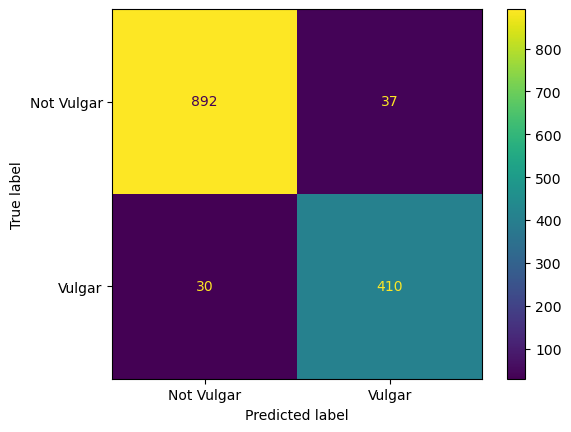

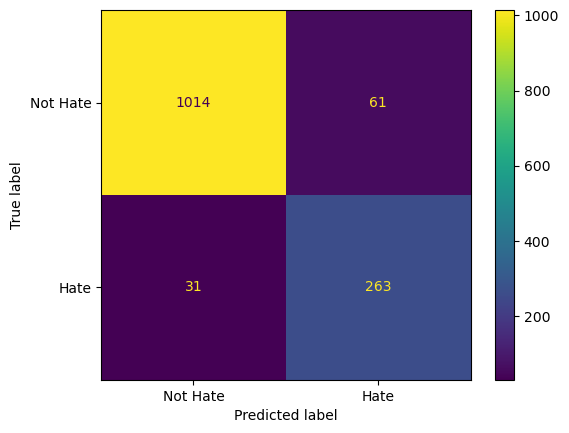

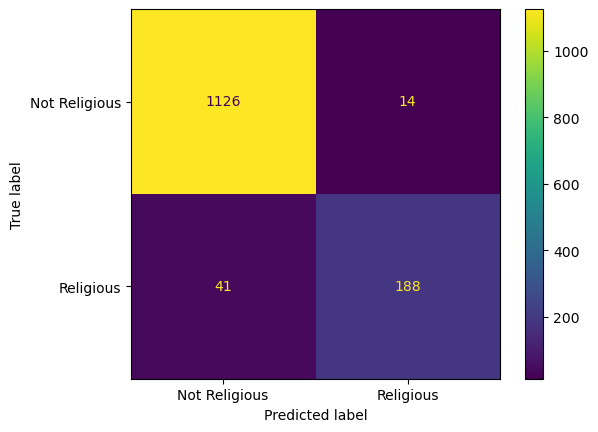

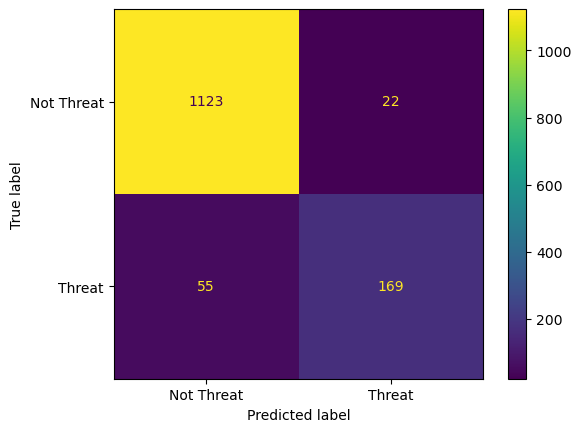

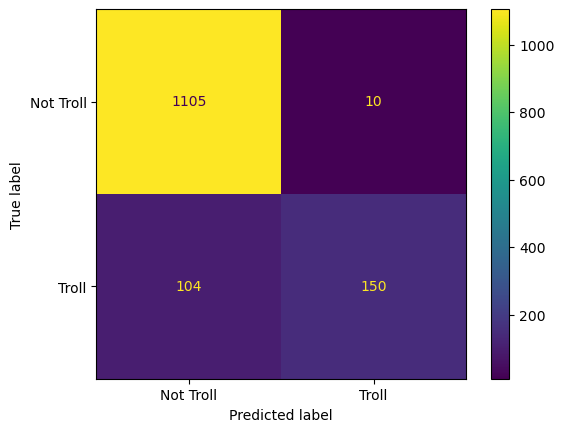

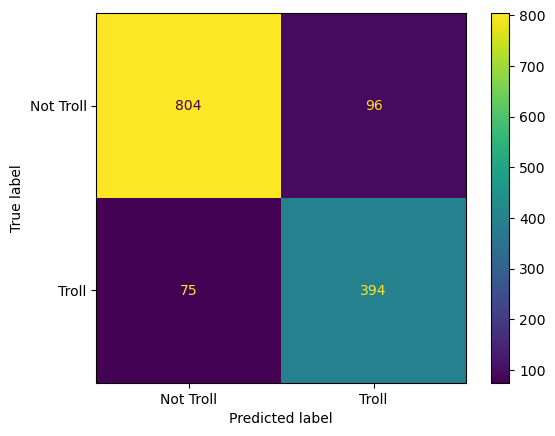

In [81]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


cm_vulgar = metrics.ConfusionMatrixDisplay(confusion_matrix = vulgar, display_labels = ['Not Vulgar', 'Vulgar'])
cm_hate = metrics.ConfusionMatrixDisplay(confusion_matrix = hate, display_labels = ['Not Hate', 'Hate'])
cm_religious = metrics.ConfusionMatrixDisplay(confusion_matrix = religious, display_labels = ['Not Religious', 'Religious'])
cm_threat = metrics.ConfusionMatrixDisplay(confusion_matrix = threat, display_labels = ['Not Threat', 'Threat'])
cm_troll = metrics.ConfusionMatrixDisplay(confusion_matrix = troll, display_labels = ['Not Troll', 'Troll'])
cm_insult = metrics.ConfusionMatrixDisplay(confusion_matrix = insult, display_labels = ['Not Troll', 'Troll'])

cm_vulgar.plot()
cm_hate.plot()
cm_religious.plot()
cm_threat.plot()
cm_troll.plot()
cm_insult.plot()

plt.show()

In [82]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.49537262283265593)

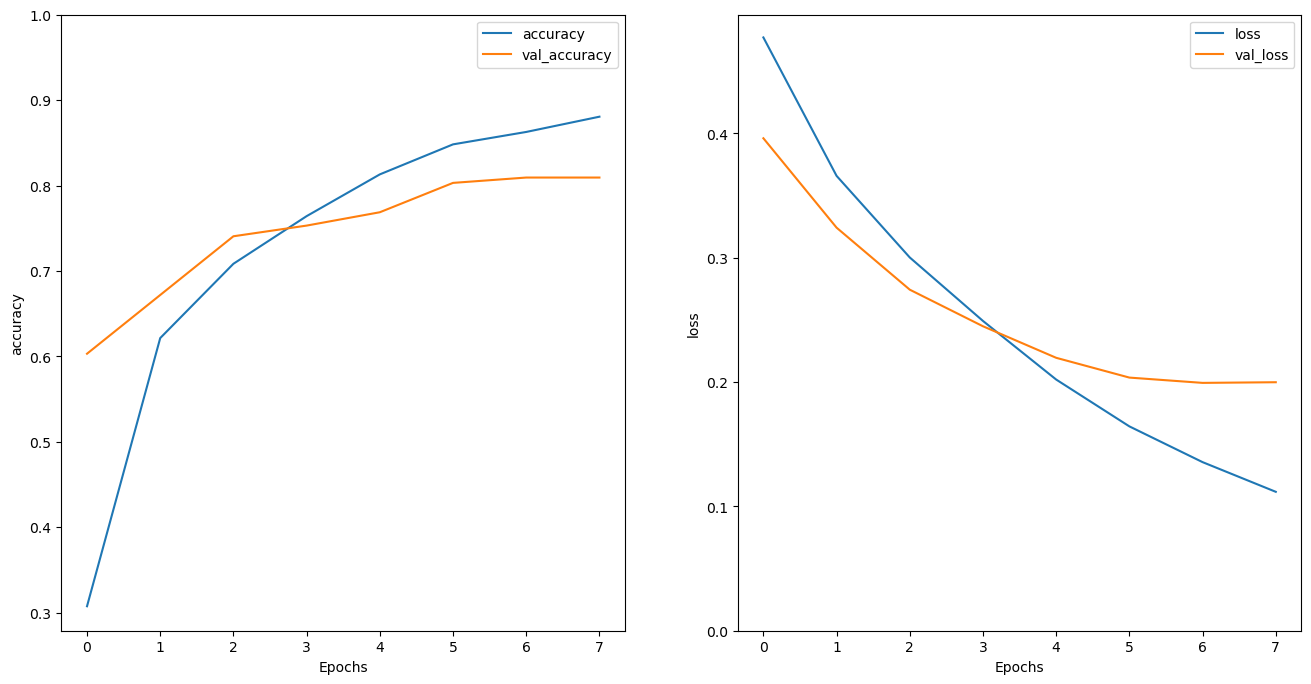

In [83]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [66]:
model.save_weights("/kaggle/working/CNN_BiLSTM_ATTENTION_Multi80")

In [67]:
!zip -r CNN_BiLSTM_ATTENTION_Multi80.zip "/kaggle/working/"

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/__notebook_source__.ipynb (deflated 44%)
  adding: kaggle/working/toxic_detection_model_plot.png (deflated 22%)
  adding: kaggle/working/CNN_BiLSTM_ATTENTION_Multi80.index (deflated 82%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/checkpoint (deflated 42%)
  adding: kaggle/working/CNN_BiLSTM_ATTENTION_Multi80.data-00000-of-00001 (deflated 35%)


In [67]:
model1 = model

In [68]:
model1.load_weights("/kaggle/input/savedmodel/CNN_LSTM_ATTENTION_BERT_WITH_ATTENTION_UPD")

In [ ]:
#sample_text = ['খানকির পুলা', 'মেরে সাফা করে ফেল', 'নাটকটা খুব সুন্দর আমার খুব ভাল লেগেছে']
#sample_text = bert_encode(['নাটকটা খুব সুন্দর আমার খুব ভাল লেগেছে'])


In [80]:
LABEL_COLUMNS

['vulgar', 'hate', 'religious', 'threat', 'troll', 'Insult']

Predicting New Sentence

In [69]:
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=300, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=LABEL_COLUMNS):
    probs = model.predict(processed_data)[0]
    return np.where(probs >= Threshold, upper, lower)

input_text = clean_doc('ভারত রেন্ডিমাগি পাকিস্তান খাংকীমাগির পুত। মরুক দুই বানচোত।')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(model1, processed_data=processed_data)
print(f"Classification results: {result}")

1/1 [==============================] - 0s 60ms/step
Classification results: [1 0 0 0 0 1]


Explain With XAI

In [121]:
%%capture
!pip3 install lime

In [70]:
from lime.lime_text import LimeTextExplainer
class_names=['vulgar', 'hate', 'religious', 'threat', 'troll', 'insult']
explainer= LimeTextExplainer(class_names=class_names, split_expression=' ')

def predict_proba(arr):
    total_preds=[]
    for i in arr:
        tokens = prepare_data(i, tokenizer)
        preds = model1.predict(tokens)[0]
        total_preds.append(preds)
    
    returnable = []
    for i in total_preds:
        temp = i
        returnable.append(np.array(temp))

    return np.array(returnable)

In [71]:
%%capture
sentence = clean_doc('কি হিংসে হয়')
exp = explainer.explain_instance(sentence, predict_proba, num_features=10, num_samples=400, labels=[0, 1, 2, 3, 4, 5])

In [72]:
print('Text: কি হিংসে হয়')
exp.show_in_notebook(text=True, show_predicted_value=True, predict_proba=True)

Text: কি হিংসে হয়


In [87]:
%%capture
sentence = clean_doc('খানকির পো এডমিন তুই কি সবাইরে খোকা খুকু মনে করস? ঠাকুমার ঝুলির গল্প শোনাইতে আইসো ।')
exp = explainer.explain_instance(sentence, predict_proba, num_features=10, num_samples=400, labels=[0, 5])

In [88]:
print('Text: খানকির পো এডমিন তুই কি সবাইরে খোকা খুকু মনে করস? ঠাকুমার ঝুলির গল্প শোনাইতে আইসো ।')
exp.show_in_notebook(text=True)

Text: খানকির পো এডমিন তুই কি সবাইরে খোকা খুকু মনে করস? ঠাকুমার ঝুলির গল্প শোনাইতে আইসো ।


In [ ]:
print('Text: মাদারটোস্ট পান্জাবী এইটা আর কয়বছর গায়ে দিবি??')
sentence = clean_doc('মাদারটোস্ট পান্জাবী এইটা আর কয়বছর গায়ে দিবি??')
exp = explainer.explain_instance(sentence, predict_proba, num_features=40, num_samples=400, labels=[0, 1, 2, 3, 4, 5])

In [ ]:
print('Text: মাদারটোস্ট পান্জাবী এইটা আর কয়বছর গায়ে দিবি??')
exp.show_in_notebook(text=True)

Text: মাদারটোস্ট পান্জাবী এইটা আর কয়বছর গায়ে দিবি??


In [ ]:
sentence = 'ধর্ম নিয়ে ব্যবসা'
exp = explainer.explain_instance(sentence, predict_proba, num_features=40, num_samples=400, labels=[0, 1, 2, 3, 4, 5])

In [ ]:
exp.show_in_notebook(text=True)

In [ ]:
exp_label = exp.available_labels()

for i in exp_label:
    print(LABEL_COLUMNS[i], " ",exp.as_list(label=i), end="\n\n")

In [ ]:
exp.predict_proba

In [86]:
#%% ROC-AUC Curve

#y_score = cv_model.predict_proba(X_test)
y_score = model.predict([X_input_ids_test, X_attn_masks_test])

from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Learn to predict each class against the other


n_classes = 6 # number of class




# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

43/43 [==============================] - 17s 400ms/step


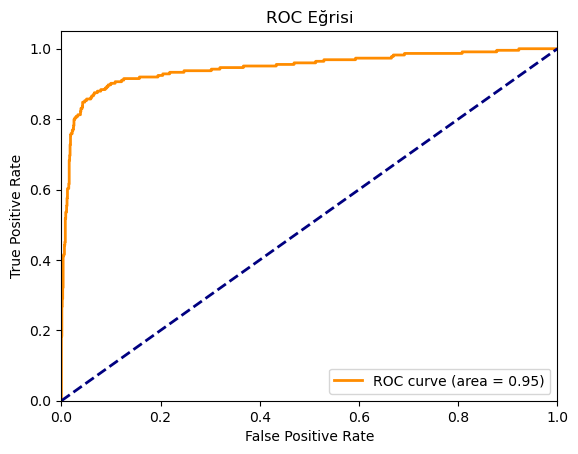

In [87]:
# The process of drawing a roc-auc curve belonging to a specific class

plt.figure()
lw = 2 # line_width
plt.plot(fpr[3], tpr[3], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[3]) # Drawing Curve according to 3. class 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()

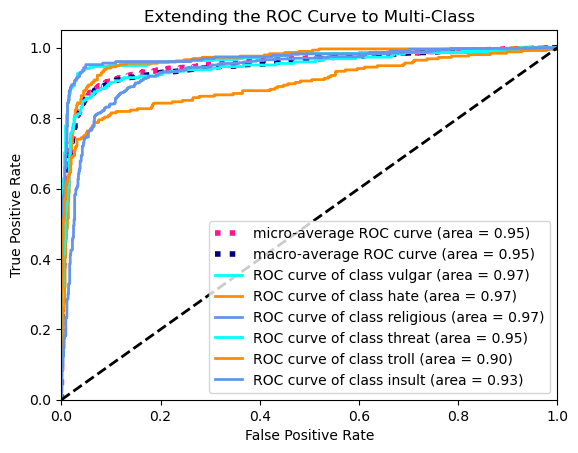

In [89]:
class_names=['vulgar', 'hate', 'religious', 'threat', 'troll', 'insult']
# Process of plotting roc-auc curve belonging to all classes.

from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

k = 0
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class '+ class_names[k] + ' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    k = k+1

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extending the ROC Curve to Multi-Class')
plt.legend(loc="lower right")
plt.show()